In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

In [9]:
# Read the CSV file
df = pd.read_csv('/Users/lukishyadav/Desktop/Engineering/case_study/ai_strike/data/data_head/df_head_500.csv')

In [10]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])


Hourly Anomalies:
           Date  Hour  OrgId  count  is_anomaly_count
102  2024-06-04    10      2      2              True
108  2024-06-04    14      1      2              True
279  2024-06-09     2      0      2              True
347  2024-06-11     8      0      2              True
427  2024-06-13     1     37      3              True

Category-Grade Anomalies:
Category       IncidentGrade
InitialAccess  TruePositive     124
dtype: int64

IP Address Anomalies:
IpAddress
360606    403
Name: count, dtype: int64

Critical Incidents Summary:
Category
InitialAccess       221
Execution            17
CredentialAccess     16
Name: count, dtype: int64


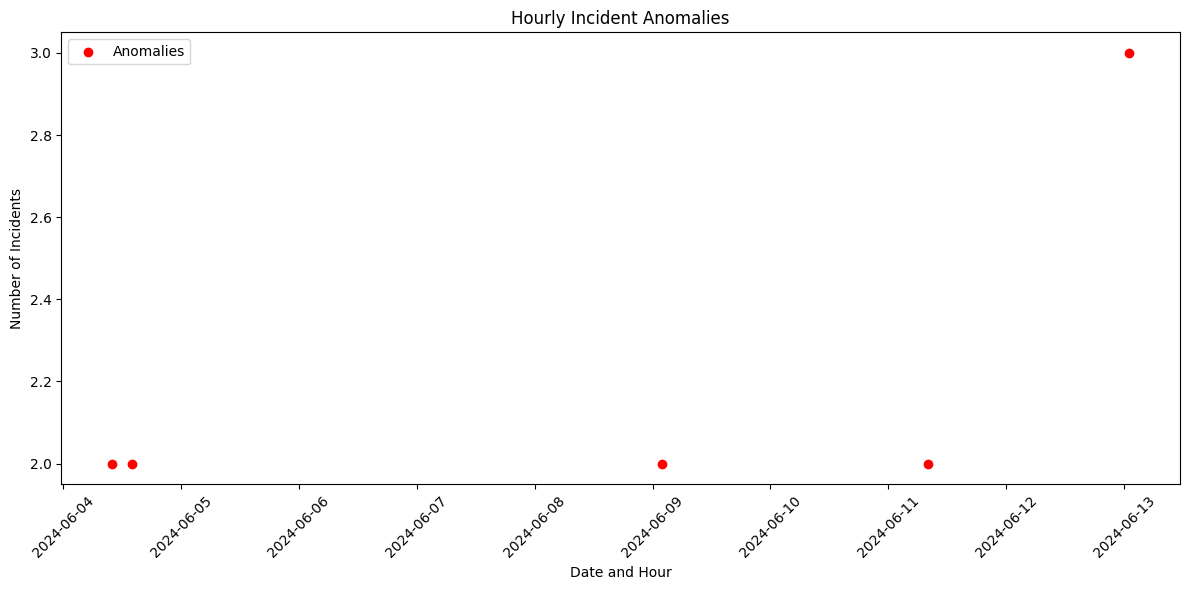

In [12]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

def detect_anomalies(df):
    # 1. Z-score based anomaly detection for incident frequency
    def z_score_anomalies(data, threshold=3):
        mean = np.mean(data)
        std = np.std(data)
        z_scores = np.abs((data - mean) / std)
        return z_scores > threshold
    
    # Group incidents by hour and organization with renamed columns
    hourly_org_incidents = df.groupby([
        df['Timestamp'].dt.date.rename('Date'),  # Rename to avoid conflict
        df['Timestamp'].dt.hour.rename('Hour'),  # Rename to avoid conflict
        'OrgId'
    ]).size().reset_index(name='count')
    
    # Detect anomalies based on:
    
    # 1. Unusual number of incidents
    hourly_org_incidents['is_anomaly_count'] = z_score_anomalies(hourly_org_incidents['count'])
    
    # 2. Unusual patterns based on Category and IncidentGrade
    category_grade_counts = df.groupby(['Category', 'IncidentGrade']).size()
    category_grade_zscore = z_score_anomalies(category_grade_counts)
    
    # 3. IP-based anomalies
    ip_frequency = df['IpAddress'].value_counts()
    ip_anomalies = z_score_anomalies(ip_frequency)
    
    # 4. Time-based anomalies for specific categories
    critical_categories = ['InitialAccess', 'Execution', 'CredentialAccess']
    critical_incidents = df[df['Category'].isin(critical_categories)]
    
    return {
        'hourly_anomalies': hourly_org_incidents[hourly_org_incidents['is_anomaly_count']],
        'category_grade_anomalies': category_grade_counts[category_grade_zscore],
        'ip_anomalies': ip_frequency[ip_anomalies],
        'critical_incidents': critical_incidents
    }

# Run the analysis
anomaly_results = detect_anomalies(df)

# Print results
print("\nHourly Anomalies:")
print(anomaly_results['hourly_anomalies'])

print("\nCategory-Grade Anomalies:")
print(anomaly_results['category_grade_anomalies'])

print("\nIP Address Anomalies:")
print(anomaly_results['ip_anomalies'])

print("\nCritical Incidents Summary:")
print(anomaly_results['critical_incidents']['Category'].value_counts())

# Visualize hourly anomalies
plt.figure(figsize=(12, 6))
anomalies = anomaly_results['hourly_anomalies']
plt.scatter(
    pd.to_datetime(anomalies['Date'].astype(str) + ' ' + anomalies['Hour'].astype(str) + ':00:00'),
    anomalies['count'],
    color='red',
    label='Anomalies'
)
plt.title('Hourly Incident Anomalies')
plt.xlabel('Date and Hour')
plt.ylabel('Number of Incidents')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Detecting anomalies...

=== Organization-wise Analysis ===

=== Entity-Type Analysis ===

=== Category-wise Analysis ===

Summary of Anomalies Found:

org_0:
Number of anomalies: 2

Sample anomalies:
          Date  Hour  IncidentId       Category IncidentGrade  MitreTechniques
28  2024-06-09     2           2  InitialAccess  TruePositive  T1078;T1078.004
36  2024-06-11     8           2  InitialAccess  TruePositive  T1078;T1078.004

Anomalies by grade:
IncidentGrade
TruePositive    2
Name: count, dtype: int64

Most common MITRE techniques in anomalies:
MitreTechniques
T1078;T1078.004    2
Name: count, dtype: int64

org_1:
Number of anomalies: 1

Sample anomalies:
          Date  Hour  IncidentId          Category IncidentGrade  \
41  2024-06-04    14           2  CredentialAccess  TruePositive   

              MitreTechniques  
41  T1110;T1110.003;T1110.001  

Anomalies by grade:
IncidentGrade
TruePositive    1
Name: count, dtype: int64

Most common MITRE techniques in anomalies:
Mit

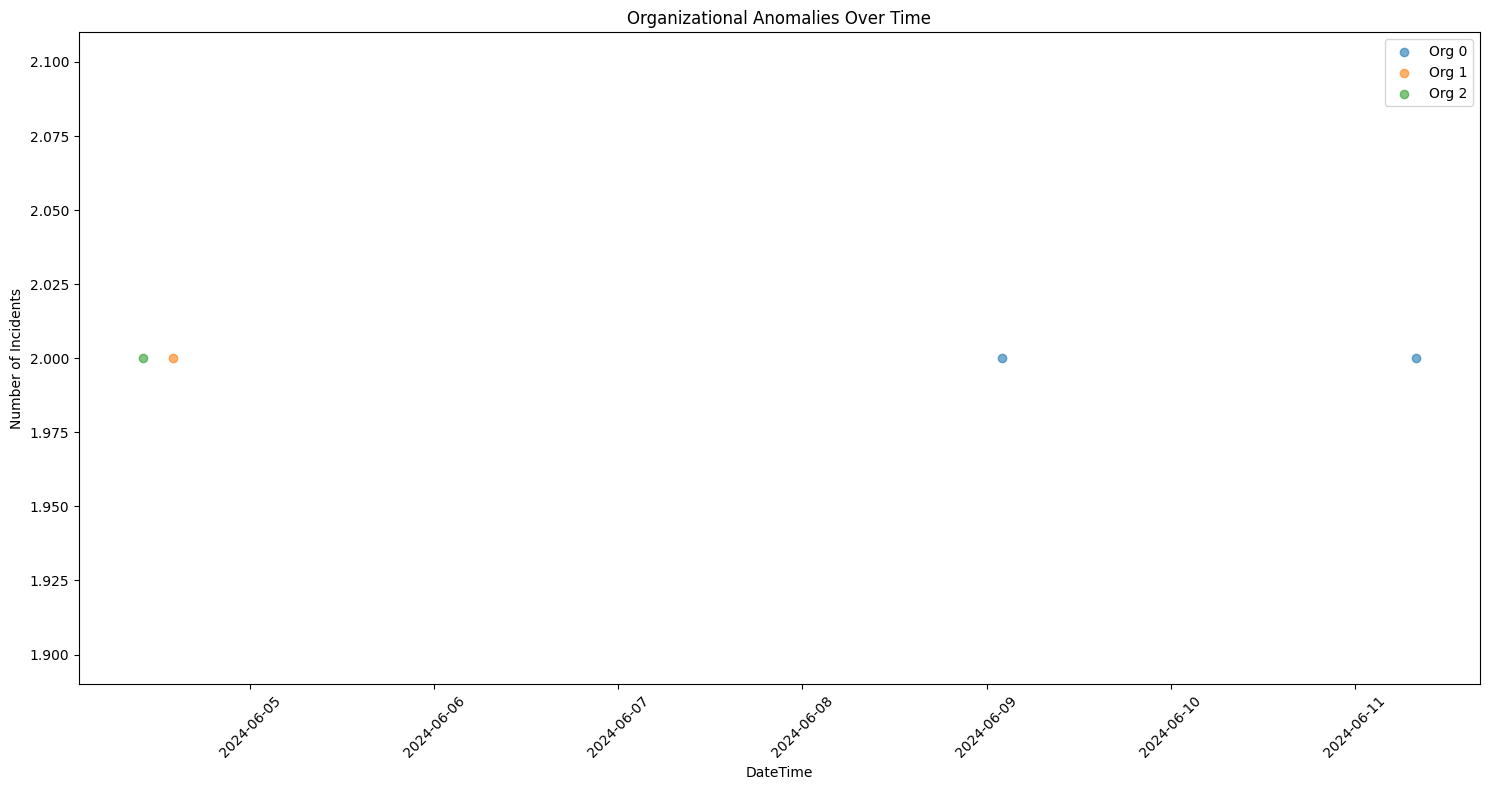

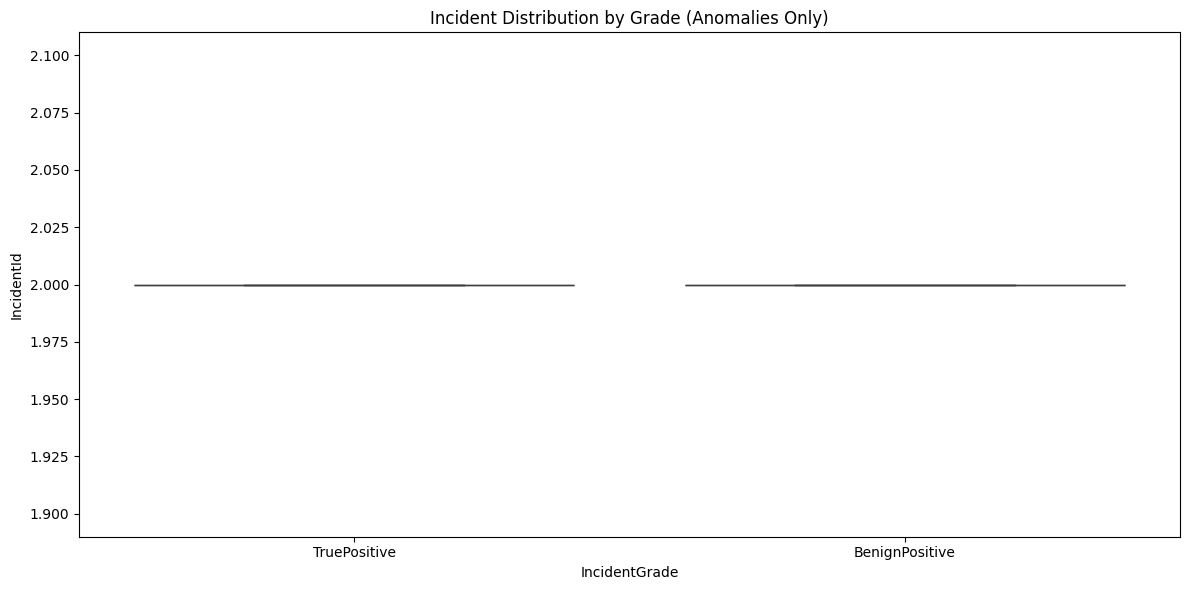


Overall Statistics:
Total number of incidents: 469
Total number of alerts: 500
Number of unique organizations: 221
Number of unique entity types: 15
Number of unique categories: 13

Most common categories:
Category
InitialAccess         221
Exfiltration           97
SuspiciousActivity     55
CommandAndControl      46
Impact                 35
Name: count, dtype: int64

Most common MITRE techniques:
MitreTechniques
T1078;T1078.004              76
T1566.002                    43
T1566                        26
T1133                         6
T1110;T1110.003;T1110.001     5
Name: count, dtype: int64


In [19]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

def get_most_common(x):
    """Safely get most common value from a series"""
    if len(x) == 0:
        return 'Unknown'
    counts = x.value_counts()
    return counts.index[0] if not counts.empty else 'Unknown'

def detect_dimensional_anomalies(df, threshold=3):
    def z_score_anomalies(data, threshold=3):
        if len(data) < 2:
            return pd.Series(False, index=data.index)
        mean = np.mean(data)
        std = np.std(data)
        if std == 0:
            return pd.Series(False, index=data.index)
        z_scores = np.abs((data - mean) / std)
        return z_scores > threshold
    
    anomaly_results = {}
    
    # 1. Organization-wise Analysis
    print("\n=== Organization-wise Analysis ===")
    org_hourly = df.groupby([
        'OrgId',
        df['Timestamp'].dt.date.rename('Date'),
        df['Timestamp'].dt.hour.rename('Hour')
    ]).agg({
        'IncidentId': 'count',  # Count of incidents
        'Category': get_most_common,  # Most common alert category
        'IncidentGrade': get_most_common,  # Most common incident grade
        'EntityType': get_most_common,  # Most common entity type
        'MitreTechniques': lambda x: get_most_common(x.fillna('None'))  # Most common MITRE technique
    }).reset_index()
    
    # For each organization, detect hourly anomalies
    for org_id in org_hourly['OrgId'].unique():
        org_data = org_hourly[org_hourly['OrgId'] == org_id].copy()
        if len(org_data) >= 2:
            org_data['is_anomaly'] = z_score_anomalies(org_data['IncidentId'])
            if org_data['is_anomaly'].any():
                anomaly_results[f'org_{org_id}'] = org_data[org_data['is_anomaly']]
    
    # 2. Entity-Type Analysis
    print("\n=== Entity-Type Analysis ===")
    entity_hourly = df.groupby([
        'EntityType',
        df['Timestamp'].dt.date.rename('Date'),
        df['Timestamp'].dt.hour.rename('Hour')
    ]).agg({
        'IncidentId': 'count',
        'Category': get_most_common,
        'IncidentGrade': get_most_common,
        'MitreTechniques': lambda x: get_most_common(x.fillna('None'))
    }).reset_index()
    
    for entity_type in entity_hourly['EntityType'].unique():
        entity_data = entity_hourly[entity_hourly['EntityType'] == entity_type].copy()
        if len(entity_data) >= 2:
            entity_data['is_anomaly'] = z_score_anomalies(entity_data['IncidentId'])
            if entity_data['is_anomaly'].any():
                anomaly_results[f'entity_{entity_type}'] = entity_data[entity_data['is_anomaly']]
    
    # 3. Category and MITRE Analysis
    print("\n=== Category-wise Analysis ===")
    category_hourly = df.groupby([
        'Category',
        df['Timestamp'].dt.date.rename('Date'),
        df['Timestamp'].dt.hour.rename('Hour')
    ]).agg({
        'IncidentId': 'count',
        'IncidentGrade': get_most_common,
        'EntityType': get_most_common,
        'MitreTechniques': lambda x: get_most_common(x.fillna('None'))
    }).reset_index()
    
    for category in category_hourly['Category'].unique():
        category_data = category_hourly[category_hourly['Category'] == category].copy()
        if len(category_data) >= 2:
            category_data['is_anomaly'] = z_score_anomalies(category_data['IncidentId'])
            if category_data['is_anomaly'].any():
                anomaly_results[f'category_{category}'] = category_data[category_data['is_anomaly']]
    
    return anomaly_results

def visualize_anomalies(df, anomaly_results):
    if not anomaly_results:
        print("No anomalies found to visualize")
        return
    
    # 1. Organization-wise visualization
    org_anomalies = {k: v for k, v in anomaly_results.items() if k.startswith('org_')}
    if org_anomalies:
        plt.figure(figsize=(15, 8))
        for org_id, anomalies in org_anomalies.items():
            org_num = org_id.split('_')[1]
            plt.scatter(
                pd.to_datetime(anomalies['Date'].astype(str) + ' ' + anomalies['Hour'].astype(str) + ':00:00'),
                anomalies['IncidentId'],
                label=f'Org {org_num}',
                alpha=0.6
            )
        plt.title('Organizational Anomalies Over Time')
        plt.xlabel('DateTime')
        plt.ylabel('Number of Incidents')
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        # Additional visualization for anomaly characteristics
        if len(org_anomalies) > 0:
            plt.figure(figsize=(12, 6))
            all_anomalies = pd.concat(org_anomalies.values())
            sns.boxplot(data=all_anomalies, x='IncidentGrade', y='IncidentId')
            plt.title('Incident Distribution by Grade (Anomalies Only)')
            plt.tight_layout()
            plt.show()

# Run the analysis
print("Detecting anomalies...")
anomaly_results = detect_dimensional_anomalies(df)

# Print summary statistics
print("\nSummary of Anomalies Found:")
for dimension, anomalies in anomaly_results.items():
    print(f"\n{dimension}:")
    print(f"Number of anomalies: {len(anomalies)}")
    if len(anomalies) > 0:
        print("\nSample anomalies:")
        print(anomalies[['Date', 'Hour', 'IncidentId', 'Category', 'IncidentGrade', 'MitreTechniques']].head())
        print("\nAnomalies by grade:")
        print(anomalies['IncidentGrade'].value_counts())
        print("\nMost common MITRE techniques in anomalies:")
        print(anomalies['MitreTechniques'].value_counts().head())

# Visualize the results
print("\nGenerating visualizations...")
visualize_anomalies(df, anomaly_results)

# Additional summary statistics
print("\nOverall Statistics:")
print(f"Total number of incidents: {df['IncidentId'].nunique()}")
print(f"Total number of alerts: {len(df)}")
print(f"Number of unique organizations: {df['OrgId'].nunique()}")
print(f"Number of unique entity types: {df['EntityType'].nunique()}")
print(f"Number of unique categories: {df['Category'].nunique()}")
print("\nMost common categories:")
print(df['Category'].value_counts().head())
print("\nMost common MITRE techniques:")
print(df['MitreTechniques'].value_counts().head())